# Tutorial 5: Convolutional Neural Networks

Convolutional neural networks (CNNs) are similar to feedforward neural networks (i.e., multilayer perceptrons or MLPs) in that they are made up a series of layers, with layers consisting of a linear transformation followed by a non-linear activation function. However, CNNs are different from MLPs in that they assume the input data is spatial, i.e., given by a grid of pixels forming a one, two, or three dimensional image. The form of the linear transformation is also different in CNNs than in MLPs: while MLPs involve multiplying the input at each layer by a matrix of size $\mathbb{R}^{d_{in} \times d_{out}}$, CNNs perform convolutions between the input at each layer and a set of spatial filters which are much smaller than the input. In two dimensions, each filter might be of size $\mathbb{R}^{3\times 3}$ or $\mathbb{R}^{5\times 5}$. These convolutional layers tend to use many fewer parameters than MLPs, as we will see.

The defining aspect of a CNN is the convolutional layer. However, CNNs can also involve other layers. For example, pooling layers are often used to reduce the size of the input. A pooling layer takes a $p \times p$ patch of the input, and outputs a single pixel which involves applying a linear or non-linear operation to that patch of pixels. One popular pooling operation is the max-pool, which outputs the maximum value of the pixels in the patch. A pooling operation transforms an input of size $\mathbb{R}^{n_x \times n_y \times d}$ to one of size $\mathbb{R}^{n_x/p \times n_y/p \times d}$ where $f$ is the "depth" of the input. CNNs can also have feedforward layers, in which a matrix multiplication is performed. These feedforward layers are usually applied towards the end of a CNN, after convolutional layers and pooling layers have been applied.

CNNs can be understood as encoding the inductive bias that the output of the neural network should be invariant to translation of the input image. For example, if a neural network is used for classification, we know a priori that an image of a cat (given as a matrix of pixels) should be labeled as a cat regardless of where in the image the cat appears. Shifting the cat to the left, right, up, or down should not change the fact that the image remains of a cat. This inductive bias appears in CNNs due to the shift equivariance of the convolutional layers: if the input to a convolution is shifted to the right or left, the output of the convolution is also shifted to the right or left. (Although CNNs attempt to encode the inductive bias of translation invariance, they are not in fact translation equivariant, for a variety of reasons. Nevertheless, CNNs work well in practice for many applications which the inductive bias of translation equivariance holds.)

Good resources on CNNs include Chapter 9 of the [Deep Learning Book](https://www.deeplearningbook.org/) and Stanford's CS231n [course notes](https://cs231n.github.io/).

### 5.1: The Convolution Operation

In 1D, the convolution operation between two continuous functions $f(x)$ and $g(x)$ is given by $$f*g(x) = \int_{-\infty}^{\infty} f(x-y) g(y) dy.$$ For two vectors $I$ and $F$ in 1D, the $i$th index of their convolution is given by $$(I*F)_i = \sum_{j}I_{i-j}F_j.$$ Let's illustrate with an example. Suppose $I = \begin{bmatrix}1 \\ 2 \\ 3 \\ 4 \\ 5 \end{bmatrix}$ and $F = \begin{bmatrix}-0.5 \\ 1.0 \end{bmatrix}$. The convolution of $I$ and $F$ is given by $$I*F = \begin{bmatrix} I_0 F_0 \\ I_1 F_0 + I_0 F_1 \\ I_2 F_0 + I_1 F_1 \\ I_3 F_0 + I_2 F_1 \\ I_4 F_0 + I_3 F_1 \\ I_4 F_1 \end{bmatrix} = \begin{bmatrix} 1*-0.5 \\ 2*-0.5 + 1*1 \\ 3*-0.5 + 2 * 1 \\ 4 * -0.5 + 3 * 1 \\ 5 * -0.5 + 4 * 1 \\ 5 * 1 \end{bmatrix} = \begin{bmatrix} -0.5 \\ 0 \\ 0.5 \\ 1 \\ 1.5 \\ 5 \end{bmatrix}.$$ We can verify this using `jax.numpy`.

In [1]:
import numpy as np

I = np.asarray([1.,2.,3.,4.,5.])
F = np.asarray([-0.5, 1.0])

conv = np.convolve(I, F)
print(conv)

[-0.5  0.   0.5  1.   1.5  5. ]


The convolution operation can be understood as extracting patches of an image $I$ equal in size to the size of the convolutional filter $F$, and taking the dot product of each patch times the (reversed) filter. 

Note that there are different types of convolutions. In the above example, we used the `full` convolution. Every possible convolutional operation was performed, so the resulting vector was of length $len(I)+len(F) - 1$. We could also have performed a `same` convolution, which returns a vector of length $max(len(I), len(F))$, or a `valid` convolution, which returns a vector of length $max(len(I), len(F)) - min(len(I), len(F)) + 1$.

In [2]:
conv_full = np.convolve(I, F, mode = 'full')
conv_same = np.convolve(I, F, mode = 'same')
conv_valid = np.convolve(I, F, mode = 'valid')

print(conv_full.shape)
print(conv_same.shape)
print(conv_valid.shape)

print(conv_full)
print(conv_same)
print(conv_valid)

(6,)
(5,)
(4,)
[-0.5  0.   0.5  1.   1.5  5. ]
[-0.5  0.   0.5  1.   1.5]
[0.  0.5 1.  1.5]


`full` and `same` convolutions involve padding one or the inputs with zeros, while `valid` convolutions do not involve padding. 

#### 5.1.1: Convolution as matrix multiplication

The convolution operation can be interpreted as performing a matrix multiplication. The matrix corresponding to a convolutional filter is sparse, and many of the entries are identical. 

To perform a `full` convolution operation between $I$ and $F$ from the previous example as a matrix multiplication, we begin by padding $I$ with $len(F) - 1$ zeros. We then convert $F$ into a Toeplitz matrix and multiply the padded vector times the matrix.

In [3]:
def matrix_convolution(I, F, mode = 'full'):
    assert mode == 'full'
    assert len(I.shape) == len(F.shape) == 1
    
    # I should be longer than F
    if F.shape[0] > I.shape[0]: 
        temp = F
        F = I
        I = temp
        
    # pad I with zeros
    pad_left = np.zeros(np.floor((F.shape[0]-1)/2).astype(int))
    pad_right = np.zeros(np.ceil((F.shape[0]-1)/2).astype(int))
    I_padded = np.append(np.append(pad_left, I), pad_right)

    # construct Toeplitz matrix
    toeplitz_matrix = np.zeros((I_padded.shape[0], I_padded.shape[0]))
    for i in range(I_padded.shape[0]):
        for j in range(F.shape[0]):
            if i - j >= 0 and i - j <= I_padded.shape[0]:
                toeplitz_matrix[i,i-j] = F[j]

    return toeplitz_matrix @ I_padded
    

In [4]:
I = np.asarray([1.,2.,3.,4.,5.])
F = np.asarray([-0.5, 1.0])

conv = matrix_convolution(I, F)
print(conv)

[-0.5  0.   0.5  1.   1.5  5. ]


We won't perform `same` or `valid` convolutions using matrix multiplication, but those can also be done using matrix multiplication.

### 5.2: Convolutional layers for image recognition

An image is given by a 2D matrix of pixels of size $\mathbb{R}^{n_x \times n_y \times d_{in}}$, where $d_{in}$ is the number of dimensions for each pixel in the image. For a grayscale image, $d_{in} = 1$, while for an image using the RGB scheme, $d_{in} = 3$.

A convolutional layer applies a series of 2D convolutional filters to the input matrix. Typically, these filters are of shape $\mathbb{R}^{3\times 3}$ or $\mathbb{R}^{5\times 5}$, and the inputs are padded with zeros to perform a `same` convolution. There are $d_{out}$ filters, so that a convolutional layer is a tranformation from $$\mathbb{R}^{n_x \times n_y \times d_{in}} \rightarrow \mathbb{R}^{n_x \times n_y \times d_{out}}.$$ For a 2D image $I$, each convolutional filter $F$ performs the operation $$(I*F)_{i,j} = \sum_k \sum_l I_{i+k,j+l}F_{k,l}.$$ Note that this operation is not exactly a convolution: in a convolution, the filter $F$ is reversed, so that the indices go as $i-k$ and $j-l$. Here the filter $F$ is not reversed. This operation, which is very similar to a convolution, is called the cross-correlation. 

We can implement convolutional layers in `flax` as follows. We'll implement a simple network with two convolutional layers. 

In [5]:
import flax
import jax
import jax.numpy as jnp
from flax import nnx

In [6]:
class ConvLayers(nnx.Module):
    def __init__(self, din: int, dmid: int, dout: int, kernel_width: int, rngs: nnx.Rngs):
        self.conv1 = nnx.Conv(din, dmid, kernel_size = (kernel_width, kernel_width), rngs=rngs)
        self.conv2 = nnx.Conv(dmid, dout, kernel_size = (kernel_width, kernel_width), rngs=rngs)

    def __call__(self, x):
        x = nnx.relu(self.conv1(x))
        x = nnx.relu(self.conv2(x))

Our network will take an image of pixels with 3 features per pixel. The first convolutional layer will output an image with 16 feature dimensions per pixel, and the second convolutional layer will have 32 feature dimensions per pixel. We'll use a kernel of width 3, meaning that each convolutional filter is of size (3, 3).

In [7]:
rngs = nnx.Rngs(0)
model = ConvLayers(3, 16, 32, 3, rngs)

We can see the parameters of the model below.

In [8]:
nnx.display(model)

ConvLayers(
  conv1=Conv(
    kernel_shape=(3, 3, 3, 16),
    kernel=Param(
      value=Array(shape=(3, 3, 3, 16), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(16,), dtype=float32)
    ),
    in_features=3,
    out_features=16,
    kernel_size=(3, 3),
    strides=1,
    padding='SAME',
    input_dilation=1,
    kernel_dilation=1,
    feature_group_count=1,
    use_bias=True,
    mask=None,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x10a6f8180>,
    bias_init=<function zeros at 0x109c18360>,
    conv_general_dilated=<function conv_general_dilated at 0x1095b2c00>
  ),
  conv2=Conv(
    kernel_shape=(3, 3, 16, 32),
    kernel=Param(
      value=Array(shape=(3, 3, 16, 32), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(32,), dtype=float32)
    ),
    in_features=16,
    out_features=32,
    kernel_size=(3, 3),
    strides=1,
    padding='SAME',
    input_dila

Although every pixel in the input is not connected to every pixel in the output (each pixel in the output is only affected by 9 pixels in the input, corresponding to a 3x3 patch around that pixel in the input image), every feature dimension in the input is connected to every feature dimension in the output. This means that each pixel in each of the 16 dimensions in the output to convolutional layer 1 is equal to the sum of three convolutions, over each of the three input dimensions, plus a constant bias term. Similarly, each of the 32 dimensions in the output of convolutional layer 2 is equal to the sum of 16 convolutions, plus a constant bias term. 

How many parameters are in our model? In layer 1, each convolutional filter is of size 3x3. There are $d_{in}\times d_{out} = 3 \times 16$ convolutional filters in layer 1, plus $d_{out} = 16$ bias terms, for a total of $3\times 3 \times 3 \times 16 + 16 = 448$ parameters in layer 1. In layer 2, there are $3 \times 3 \times 16 \times 32 + 32 = 4,640$ parameters. Thus, the model has a total of 5088 parameters.

In [24]:
graphdef, params = nnx.split(model, nnx.Param)
print(sum(x.size for x in jax.tree.leaves(params)))

824458


### 5.3: Convolutional Neural Networks for classification on MNIST

One of the tutorial examples for using `flax` is to train a convolutional neural network on MNIST. 

#### 5.3.1: Implement CNN model

First, we will implement a convolutional neural network in flax. We will use two convolutional layers, with each layer followed by a ReLU non-linearity and a max pooling operation. We'll then reshape our hidden units into a single feature vector, and apply one feedforward layers followed by one linear layer.

Our first conv layer's output will be of shape $(28, 28, 32)$. We'll then apply a max pooling layer, so that the shape will be $(14, 14, 32)$. The next conv layer's output will then be $(14, 14, 64)$, to which we'll apply a max pooling layer, to give a shape of $(7, 7, 64)$. This will then be converted into a single feature vector of length $3,136$, which will be given to a feedforward layer with 256 hidden units. Our output layer will have 10 units, corresponding to each of the 10 digits in MNIST. 

In [10]:
import flax
import jax
import jax.numpy as jnp
from flax import nnx
from functools import partial
import optax

In [11]:
class ConvNetMNIST(nnx.Module):
    def __init__(self, rngs: nnx.Rngs):
        self.conv1 = nnx.Conv(1, 32, kernel_size=(3,3), rngs=rngs)
        self.conv2 = nnx.Conv(32, 64, kernel_size=(3,3), rngs=rngs)
        self.linear1 = nnx.Linear(3136, 256, rngs=rngs)
        self.linear2 = nnx.Linear(256, 10, rngs=rngs)
        self.max_pool = partial(nnx.max_pool, window_shape=(2, 2), strides=(2, 2))

    def __call__(self, x):
        x = nnx.relu(self.conv1(x))
        x = self.max_pool(x)
        x = nnx.relu(self.conv2(x))
        x = self.max_pool(x)
        x = x.flatten()
        x = nnx.relu(self.linear1(x))
        return self.linear2(x)

In [12]:
# test model

test_im = np.zeros((28, 28, 1))
model = ConvNetMNIST(nnx.Rngs(0))
print(model(test_im).shape)

(10,)


In [13]:
# visualize model
nnx.display(model)

ConvNetMNIST(
  conv1=Conv(
    kernel_shape=(3, 3, 1, 32),
    kernel=Param(
      value=Array(shape=(3, 3, 1, 32), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(32,), dtype=float32)
    ),
    in_features=1,
    out_features=32,
    kernel_size=(3, 3),
    strides=1,
    padding='SAME',
    input_dilation=1,
    kernel_dilation=1,
    feature_group_count=1,
    use_bias=True,
    mask=None,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x10a6f8180>,
    bias_init=<function zeros at 0x109c18360>,
    conv_general_dilated=<function conv_general_dilated at 0x1095b2c00>
  ),
  conv2=Conv(
    kernel_shape=(3, 3, 32, 64),
    kernel=Param(
      value=Array(shape=(3, 3, 32, 64), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(64,), dtype=float32)
    ),
    in_features=32,
    out_features=64,
    kernel_size=(3, 3),
    strides=1,
    padding='SAME',
    input_di

As we can see, most of the parameters are in the feedforward layer matrix of size 3136 by 256:

In [14]:
# count number of params
graphdef, params = nnx.split(model, nnx.Param)
print([x.size for x in jax.tree_leaves(params)])

[32, 288, 64, 18432, 256, 802816, 10, 2560]


#### 5.3.2: Input data, write loss functions

For this step, we'll reuse much of the code from tutorial 4, where we trained an MLP to classify digits using the MNIST dataset.

In [15]:
import tensorflow_datasets as tfds  # TFDS to download MNIST.
import tensorflow as tf  # TensorFlow / `tf.data` operations.
import matplotlib.pyplot as plt
tf.random.set_seed(0)  # Set the random seed for reproducibility.

train_ds: tf.data.Dataset = tfds.load('mnist', split='train', data_dir='datasets/tensorflow_datasets')
test_ds: tf.data.Dataset = tfds.load('mnist', split='test', data_dir='datasets/tensorflow_datasets')

# normalize train set
train_ds = train_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
) 
# Normalize test set
test_ds = test_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
)

batch_size = 32
num_epochs = 5
buffer_size = 1024
lr = 1e-3
momentum = 0.9

train_ds_iterator = train_ds.shuffle(buffer_size = 1024).batch(batch_size, drop_remainder=True).repeat(num_epochs).prefetch(1)
test_ds_iterator = test_ds.batch(batch_size, drop_remainder = True)

optimizer = nnx.Optimizer(model, optax.adamw(lr, momentum))

metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)

def loss_fn(model: ConvNetMNIST, batch):
    logits = nnx.vmap(model)(batch['image'])
    loss = jnp.mean(optax.softmax_cross_entropy_with_integer_labels(logits, batch['label']))
    return loss, logits

@nnx.jit
def train_step(model: ConvNetMNIST, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    grad_fn = nnx.value_and_grad(loss_fn, has_aux = True)
    (loss, logits), grads = grad_fn(model, batch)
    metrics.update(loss = loss, logits=logits, labels=batch['label'])
    optimizer.update(grads)

@nnx.jit
def eval_step(model: ConvNetMNIST, metrics: nnx.MultiMetric, batch):
  loss, logits = loss_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.

#### 5.3.3: Train model

We'll again reuse code from tutorial 4.

In [17]:
from IPython.display import clear_output
eval_every = 200

metrics_history = {
  'train_loss': [],
  'train_accuracy': [],
  'test_loss': [],
  'test_accuracy': [],
}

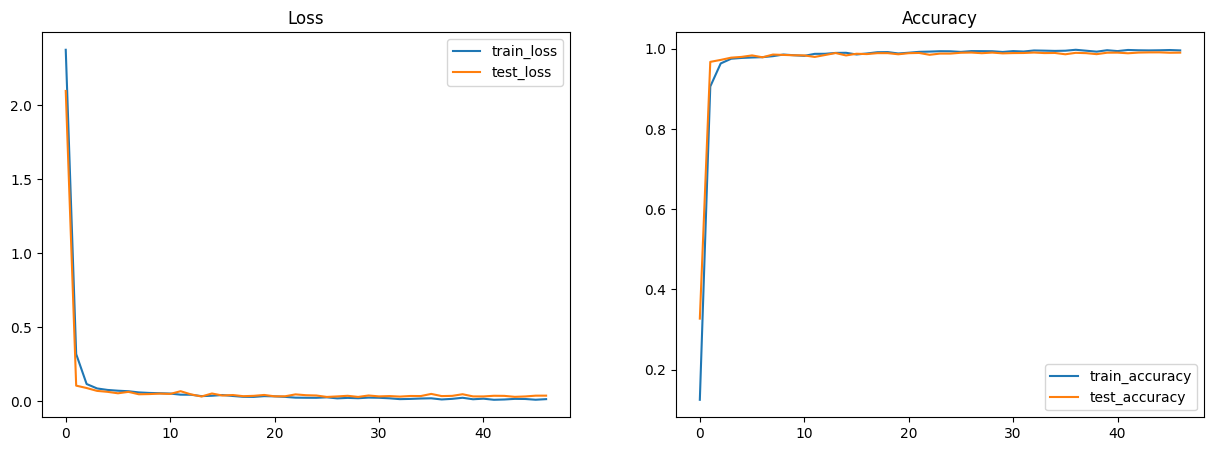

In [18]:
for step, batch in enumerate(train_ds_iterator.as_numpy_iterator()):
    train_step(model, optimizer, metrics, batch)
    
    if step % eval_every == 0:

        # log training metrics to history
        for metric, value in metrics.compute().items():
            metrics_history[f'train_{metric}'].append(value)

        # reset the metrics between each eval_every number of batches
        # also to compute metrics on the test set
        metrics.reset() 

        # loop through test set to compute metrics
        for test_batch in test_ds_iterator.as_numpy_iterator():
            eval_step(model, metrics, test_batch)

        # log testing metrics to history
        for metric, value in metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)

        # reset metrics for next set of training runs
        metrics.reset()

        # plot metrics over time
        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.set_title('Loss')
        ax2.set_title('Accuracy')
        for dataset in ('train', 'test'):
          ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
          ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
        ax1.legend()
        ax2.legend()
        plt.show()
        

In [19]:
# clear metrics
metrics.reset()

# set model to eval mode, which is unnecessary for our CNN but is required when dropout and batchnorm are used (see future tutorials)
model.eval()

for test_batch in test_ds_iterator.as_numpy_iterator():
    eval_step(model, metrics, test_batch)

print(metrics.compute()['accuracy'])

0.9911859


We get an accuracy of 99.1% on the test set. This is better than our accuracy with an MLP, which was 97%. 

In [21]:
@nnx.jit
def pred_step(model: ConvNetMNIST, batch):
    logits = nnx.vmap(model)(batch['image'])
    return logits.argmax(axis=1)

In [22]:
test_ds_iterator = test_ds.batch(25).as_numpy_iterator()

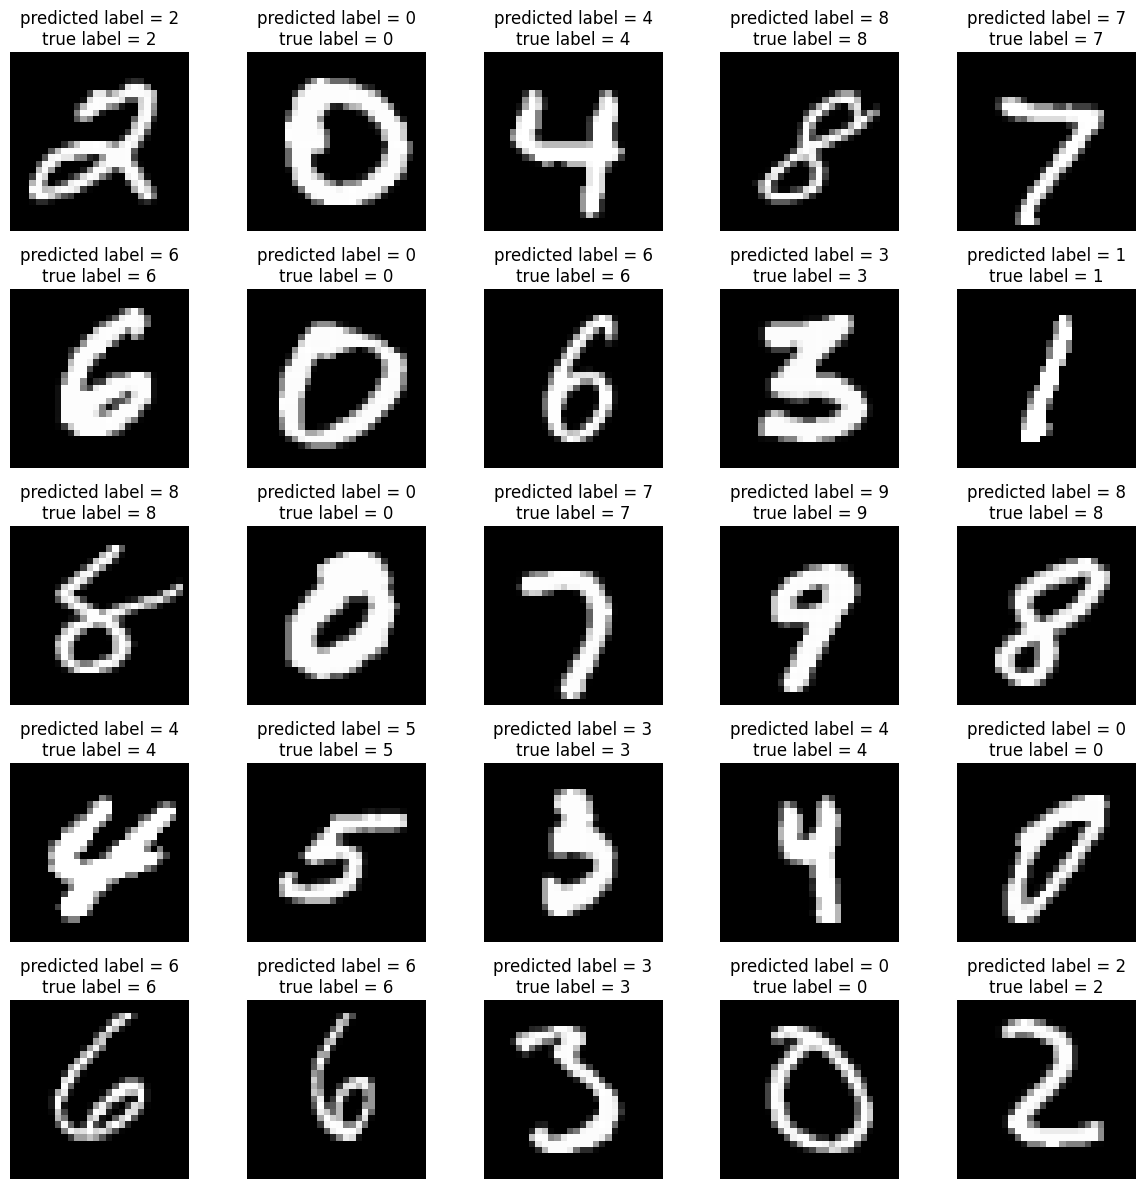

In [23]:
test_batch = test_ds_iterator.next()

preds = pred_step(model, test_batch)

fig, axs = plt.subplots(5, 5, figsize=(12, 12))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(test_batch['image'][i], cmap='gray')
    ax.set_title(f'predicted label = {preds[i]}\ntrue label = {test_batch['label'][i]}')
    ax.axis('off')
fig.tight_layout()